## Preparing kaggle environment in colab

In [ ]:
! pip install -q kaggle

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rachidy","key":"9d1f22f6b32a359f7771be91292937b1"}'}

In [ ]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

## Preparing data

In [ ]:
! kaggle datasets download dansbecker/food-101

100% 9.37G/9.38G [02:22<00:00, 109MB/s]
100% 9.38G/9.38G [02:22<00:00, 70.6MB/s]


In [ ]:
!unzip food-101

Streaming output truncated to the last 5000 lines.
  inflating: food-101/food-101/images/tacos/1030289.jpg  
  inflating: food-101/food-101/images/tacos/1033196.jpg  
  inflating: food-101/food-101/images/tacos/1036030.jpg  
  inflating: food-101/food-101/images/tacos/1042175.jpg  
  inflating: food-101/food-101/images/tacos/1044043.jpg  
  inflating: food-101/food-101/images/tacos/1058697.jpg  
  inflating: food-101/food-101/images/tacos/1059239.jpg  
  inflating: food-101/food-101/images/tacos/1059326.jpg  
  inflating: food-101/food-101/images/tacos/1066762.jpg  
  inflating: food-101/food-101/images/tacos/1070967.jpg  
  inflating: food-101/food-101/images/tacos/1073468.jpg  
  inflating: food-101/food-101/images/tacos/1075296.jpg  
  inflating: food-101/food-101/images/tacos/1085243.jpg  
  inflating: food-101/food-101/images/tacos/108529.jpg  
  inflating: food-101/food-101/images/tacos/1086014.jpg  
  inflating: food-101/food-101/images/tacos/108945.jpg  
  inflating: food-101/f

In [ ]:
import os 
images_path='/content/food-101/food-101/images/'

os.remove('/content/food-101/food-101/images/.DS_Store')

In [ ]:
import os
import random
def keep(path,percent=10):
  files=os.listdir(path)
  nb_of_files=len(files)
  x=int(nb_of_files-(nb_of_files/percent))
  files_to_remove=random.sample(files,x)

  for f in files_to_remove:
    file=path+'/'+f
    try:
      os.remove(file)
    except:
      pass
  

In [ ]:
for classe in os.listdir(images_path):
  new_path=images_path+classe
  keep(new_path,percent=10)
  

In [ ]:
!pip install split-folders

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import splitfolders


splitfolders.ratio(images_path, output="Data", seed=1337, ratio=(0.8, 0.1,0.1),move=True) 

Copying files: 10100 files [00:00, 18245.40 files/s]


In [ ]:
TRAINING_DIR = "./Data/train"
VALIDATION_DIR = "./Data/val"
TEST_DIR = "./Data/test"

## Understanding data

In [ ]:
import os
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

walk_through_dir(TRAINING_DIR)

There are 101 directories and 0 images in './Data/train'.
There are 0 directories and 80 images in './Data/train/club_sandwich'.
There are 0 directories and 80 images in './Data/train/hot_dog'.
There are 0 directories and 80 images in './Data/train/pork_chop'.
There are 0 directories and 80 images in './Data/train/lobster_roll_sandwich'.
There are 0 directories and 80 images in './Data/train/onion_rings'.
There are 0 directories and 80 images in './Data/train/risotto'.
There are 0 directories and 80 images in './Data/train/strawberry_shortcake'.
There are 0 directories and 80 images in './Data/train/samosa'.
There are 0 directories and 80 images in './Data/train/cheesecake'.
There are 0 directories and 80 images in './Data/train/ramen'.
There are 0 directories and 80 images in './Data/train/churros'.
There are 0 directories and 80 images in './Data/train/beet_salad'.
There are 0 directories and 80 images in './Data/train/waffles'.
There are 0 directories and 80 images in './Data/train/

In [ ]:
classes=os.listdir(VALIDATION_DIR)
len(classes)

101

In [ ]:
import random
def get_random_image(directory=TRAINING_DIR,classe=None):
  if classe==None:
    classe=random.choice(classes)
  path= directory + "/" + classe + "/" + random.choice(os.listdir(directory+"/"+classe))
  return (classe, path)

(512, 512, 3)


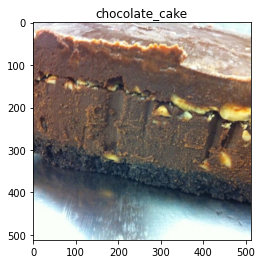

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.image import imread

random_image=get_random_image()

classe=random_image[0]
image=imread(random_image[1])

print(image.shape)

plt.title(classe)
plt.imshow(image)

## Processing

In [ ]:
input_shape=(224, 224,3)

In [ ]:
import tensorflow as tf

train_data = tf.keras.preprocessing.image_dataset_from_directory(TRAINING_DIR,
                                                                 label_mode="categorical",
                                                                 image_size=input_shape[:2])
                                                                                
validation_data = tf.keras.preprocessing.image_dataset_from_directory(VALIDATION_DIR,
                                                                label_mode="categorical",
                                                                image_size=input_shape[:2],)

test_data = tf.keras.preprocessing.image_dataset_from_directory(TEST_DIR,
                                                                label_mode="categorical",
                                                                image_size=input_shape[:2],
                                                                shuffle=False)

Found 8080 files belonging to 101 classes.
Found 1010 files belonging to 101 classes.
Found 1010 files belonging to 101 classes.


In [ ]:
checkpoint_path = "model_checkpoint"

# Create checkpoint callback to save model for later use
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                         save_weights_only=True, # save only the model weights
                                                         monitor="val_accuracy", # save the model weights which score the best validation accuracy
                                                         save_best_only=True) # only keep the best model weights on file (delete the rest)

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.models import Sequential

# Setup data augmentation
data_augmentation = Sequential([
  preprocessing.RandomFlip("horizontal"), # randomly flip images on horizontal edge
  preprocessing.RandomRotation(0.2), # randomly rotate images by a specific amount
  preprocessing.RandomHeight(0.2), # randomly adjust the height of an image by a specific amount
  preprocessing.RandomWidth(0.2), # randomly adjust the width of an image by a specific amount
  preprocessing.RandomZoom(0.2), # randomly zoom into an image
  # preprocessing.Rescaling(1./255) # keep for models like ResNet50V2, remove for EfficientNet
], name="data_augmentation")

### baseLine

In [ ]:
# Setup base model and freeze its layers (this will extract features)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False


inputs=tf.keras.layers.Input(shape=input_shape,name="Input_layer")

x = data_augmentation(inputs) # augment images (only happens during training)
x = base_model(x, training=False) # put the base model in inference mode so we can use it to extract features without updating the weights
x = layers.GlobalAveragePooling2D(name="global_average_pooling")(x) # pool the outputs of the base model
outputs = layers.Dense(len(train_data.class_names), activation="softmax", name="output_layer")(x) # same number of outputs as classes
model = tf.keras.Model(inputs, outputs)

16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 224, 224, 3)      0         
 al)                                                             
                                                                 
 efficientnetb0 (Functional)  (None, None, None, 1280)  4049571  
                                                                 
 global_average_pooling (Glo  (None, 1280)             0         
 balAveragePooling2D)                                            
                                                                 
 output_layer (Dense)        (None, 101)               129381    
                                                                 
Total params: 4,178,952
Trainable params: 129,381
Non-trainab

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(train_data,
                      epochs=5,
                      steps_per_epoch=len(train_data),
                      validation_data=validation_data,
                      validation_steps=int(0.15*len(validation_data)),
                      callbacks=[checkpoint_callback]
                     )

Epoch 1/5
253/253 [==============================] - 102s 330ms/step - loss: 3.2877 - accuracy: 0.2941 - val_loss: 2.2787 - val_accuracy: 0.5156
Epoch 2/5
253/253 [==============================] - 66s 258ms/step - loss: 2.1250 - accuracy: 0.5103 - val_loss: 1.9185 - val_accuracy: 0.5234
Epoch 3/5
253/253 [==============================] - 58s 227ms/step - loss: 1.7624 - accuracy: 0.5787 - val_loss: 1.8212 - val_accuracy: 0.5469
Epoch 4/5
253/253 [==============================] - 54s 210ms/step - loss: 1.5595 - accuracy: 0.6210 - val_loss: 1.7031 - val_accuracy: 0.5547
Epoch 5/5
253/253 [==============================] - 46s 181ms/step - loss: 1.4197 - accuracy: 0.6504 - val_loss: 1.7599 - val_accuracy: 0.5234


In [ ]:
model.evaluate(test_data)

32/32 [==============================] - 4s 112ms/step - loss: 1.7025 - accuracy: 0.5663


[1.702475666999817, 0.5663366317749023]

In [ ]:
def Mplot(history):
  
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

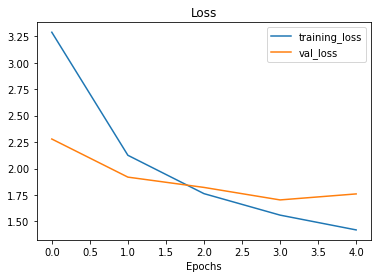

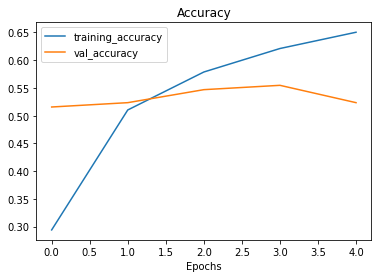

In [ ]:
Mplot(history)

### fine tuning

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable = True

# Refreeze every layer except for the last 5
for layer in base_model.layers[:-5]:
  layer.trainable = False

In [ ]:
# Recompile model with lower learning rate
model.compile(loss='categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(1e-4), # 10x lower learning rate than default
              metrics=['accuracy'])

In [ ]:
# Fine-tune for 5 more epochs
history2 = model.fit(train_data,
                     epochs=10,
                     validation_data=validation_data,
                     validation_steps=int(0.15 * len(validation_data)), # validate on 15% of the test data
                     initial_epoch=history.epoch[-1]) # start from previous last epoch

Epoch 5/10
253/253 [==============================] - 56s 188ms/step - loss: 1.1933 - accuracy: 0.6817 - val_loss: 1.6050 - val_accuracy: 0.5391
Epoch 6/10
253/253 [==============================] - 45s 176ms/step - loss: 1.0811 - accuracy: 0.7158 - val_loss: 1.5615 - val_accuracy: 0.5781
Epoch 7/10
253/253 [==============================] - 42s 166ms/step - loss: 1.0003 - accuracy: 0.7318 - val_loss: 1.6675 - val_accuracy: 0.6016
Epoch 8/10
253/253 [==============================] - 41s 160ms/step - loss: 0.9461 - accuracy: 0.7469 - val_loss: 1.5392 - val_accuracy: 0.5625
Epoch 9/10
253/253 [==============================] - 43s 166ms/step - loss: 0.8763 - accuracy: 0.7631 - val_loss: 1.5058 - val_accuracy: 0.5703
Epoch 10/10
253/253 [==============================] - 40s 157ms/step - loss: 0.8196 - accuracy: 0.7803 - val_loss: 1.5888 - val_accuracy: 0.5781


In [ ]:
def compare_historys(old_history, new_history, initial_epochs=5):
    
    # Get original history measurements
    acc = old_history.history["accuracy"]
    loss = old_history.history["loss"]

    val_acc = old_history.history["val_accuracy"]
    val_loss = old_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

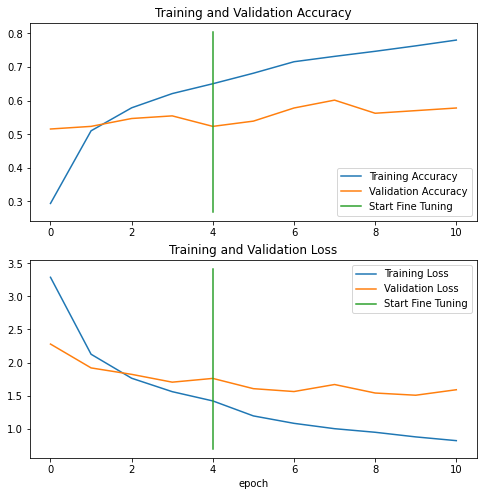

In [ ]:
compare_historys(history,history2)

In [ ]:
model.save('/content/drive/MyDrive/food_classification101_EfficientNetB0')

In [ ]:
model.evaluate(test_data)

32/32 [==============================] - 4s 130ms/step - loss: 1.6958 - accuracy: 0.5822


[1.6958261728286743, 0.5821782350540161]

In [ ]:
# Make predictions with model
pred_probs = model.predict(test_data, verbose=1)
pred_probs.shape

32/32 [==============================] - 4s 87ms/step


(1010, 101)

In [ ]:
pred_classes = pred_probs.argmax(axis=1)

In [ ]:
y_labels = []
for images, labels in test_data.unbatch(): # unbatch the test data and get images and labels
  y_labels.append(labels.numpy().argmax()) # append the index which has the largest value (labels are one-hot)
y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# Get accuracy score by comparing predicted classes to ground truth labels
from sklearn.metrics import accuracy_score
sklearn_accuracy = accuracy_score(y_labels, pred_classes)
sklearn_accuracy

0.5821782178217821

In [ ]:
import itertools
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

# Our function needs a different name to sklearn's plot_confusion_matrix

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False): 
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])
  
  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes), 
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)
  
  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

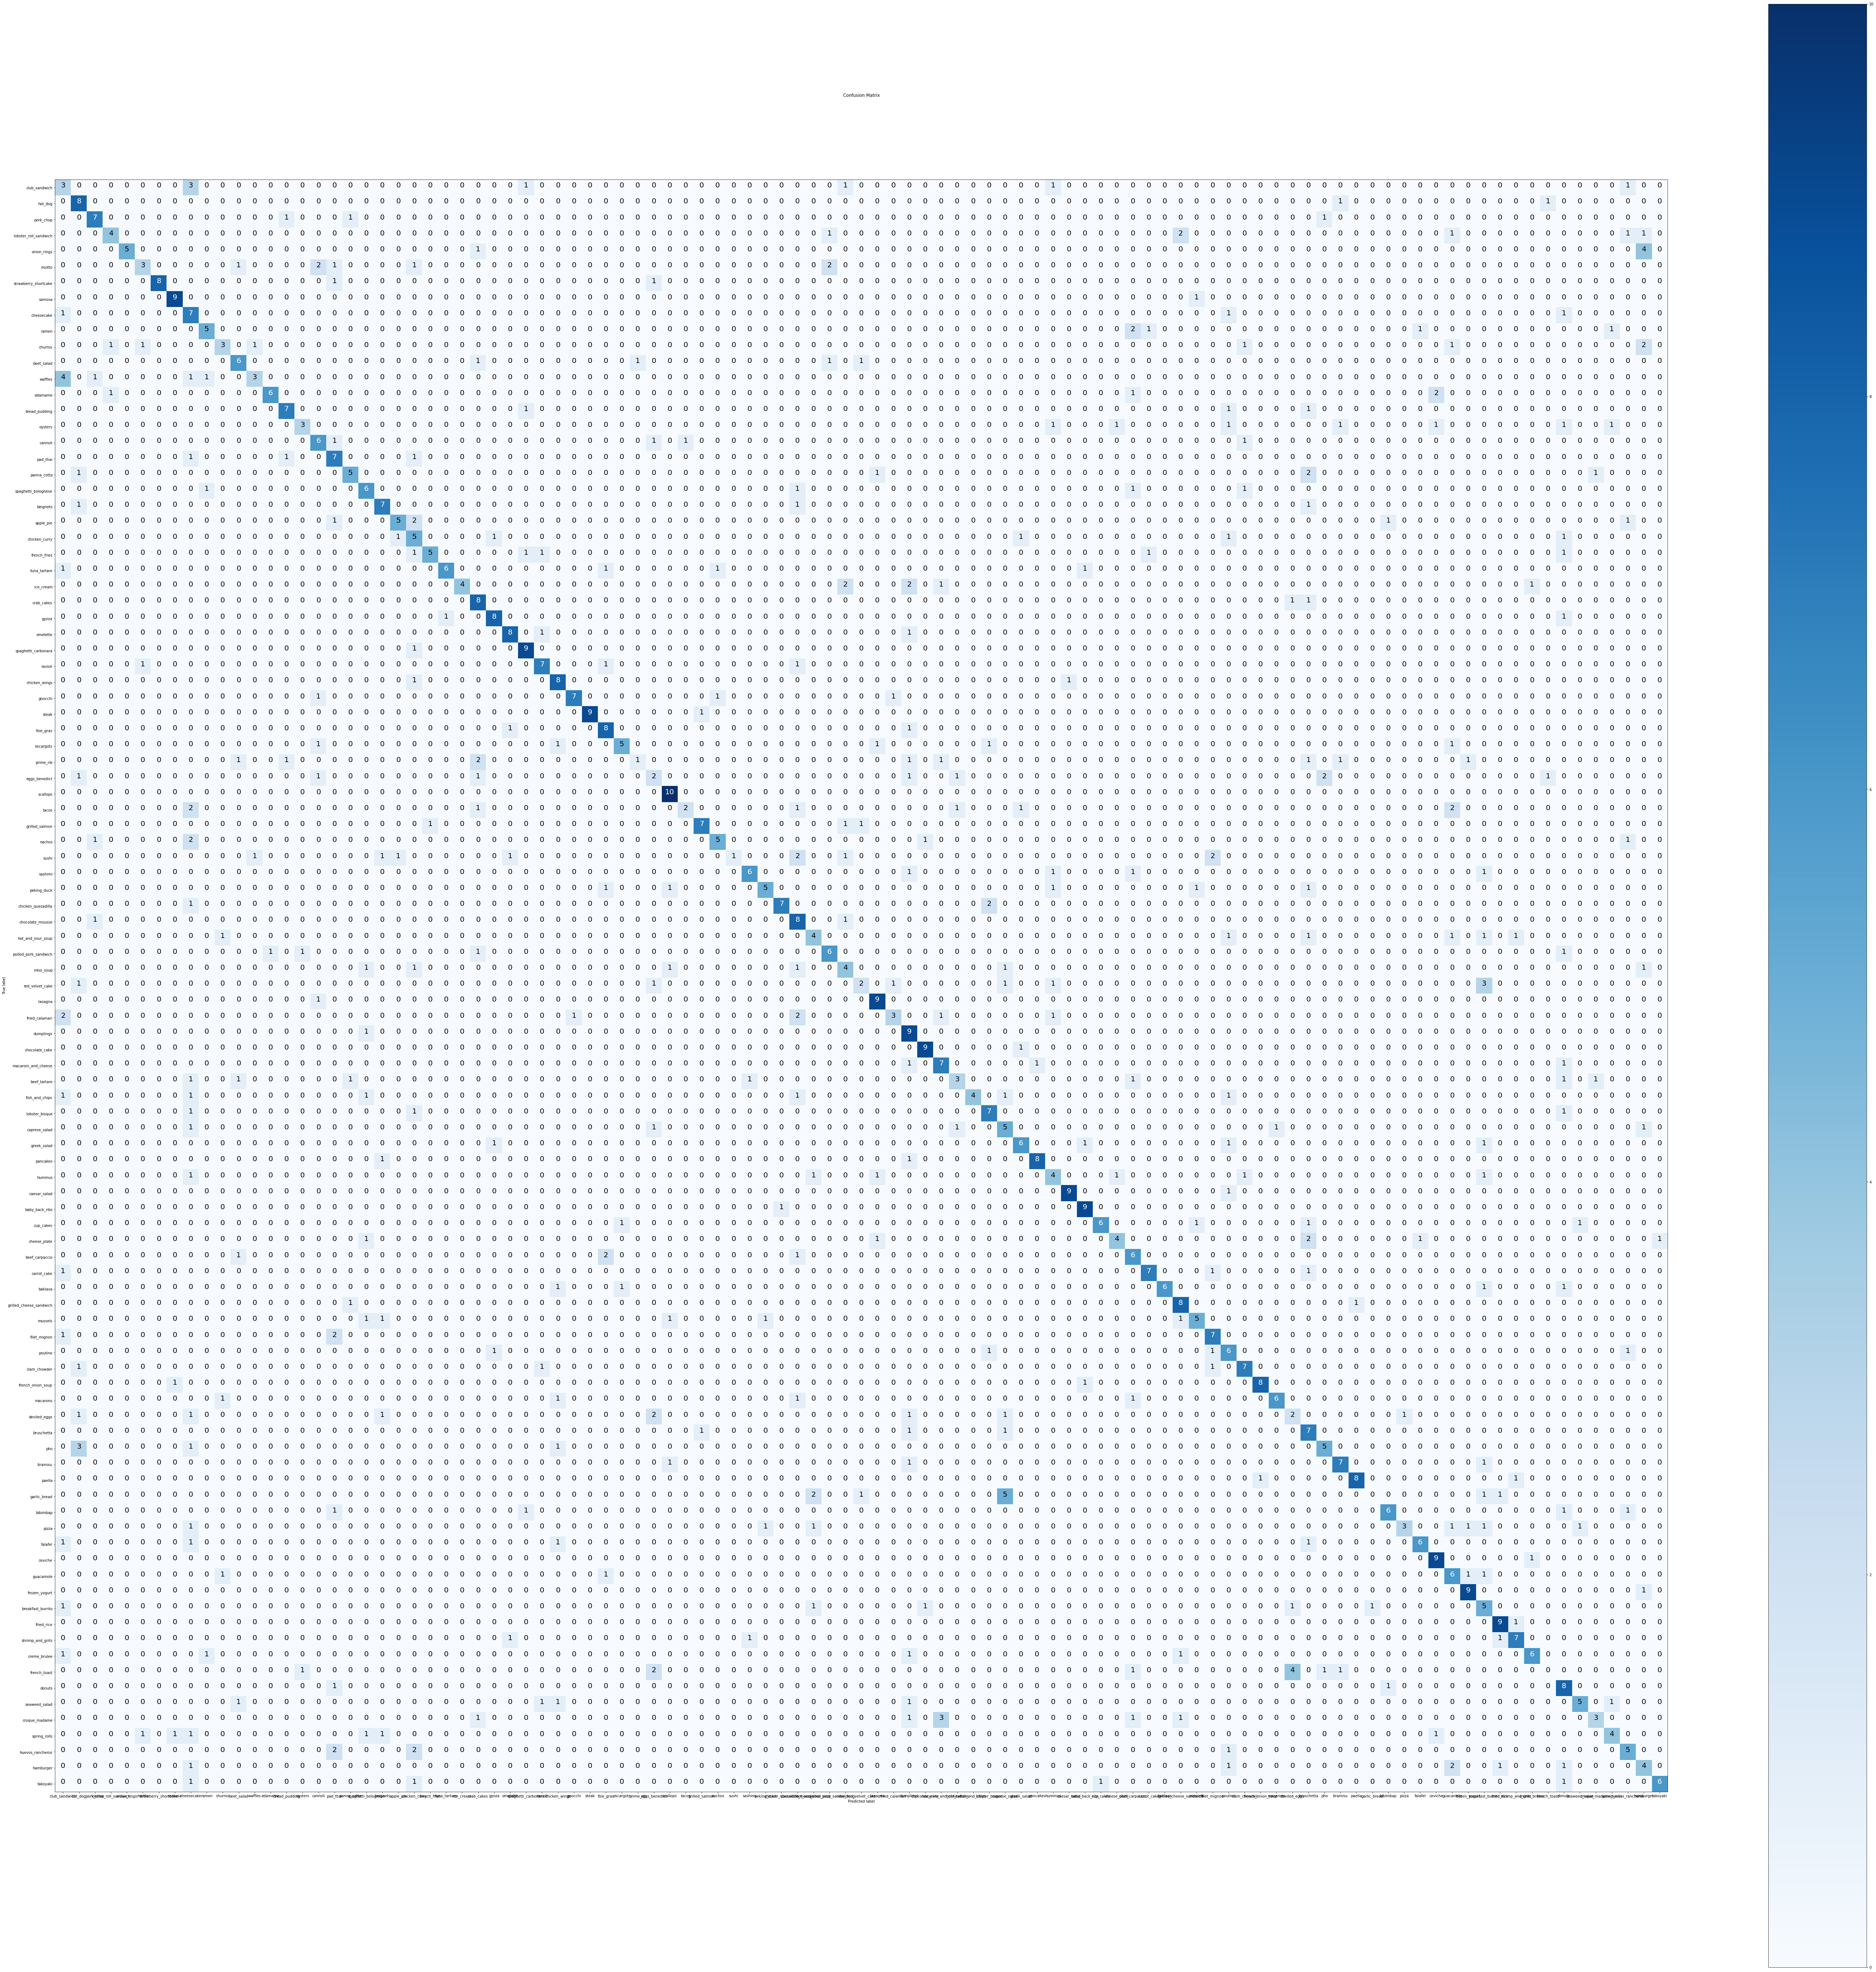

In [ ]:
make_confusion_matrix(y_true=y_labels,
                      y_pred=pred_classes,
                      classes=classes,
                      figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
from sklearn.metrics import classification_report
classification_report_dict = classification_report(y_labels, pred_classes, output_dict=True)

In [ ]:
import pandas as pd
class_f1_scores = {}
# Loop through classification report items
for k, v in classification_report_dict.items():
  if k == "accuracy": # stop once we get to accuracy key
    break
  else:
    # Append class names and f1-scores to new dictionary
    class_f1_scores[classes[int(k)]] = v["f1-score"]

f1_scores = pd.DataFrame({"class_name": list(class_f1_scores.keys()),
                          "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)
f1_scores

,class_name,f1-score
33,steak,0.947368
63,caesar_salad,0.900000
6,strawberry_shortcake,0.888889
54,chocolate_cake,0.857143
7,samosa,0.857143
...,...,...
37,eggs_benedict,0.200000
42,sushi,0.181818
36,prime_rib,0.166667
93,french_toast,0.000000


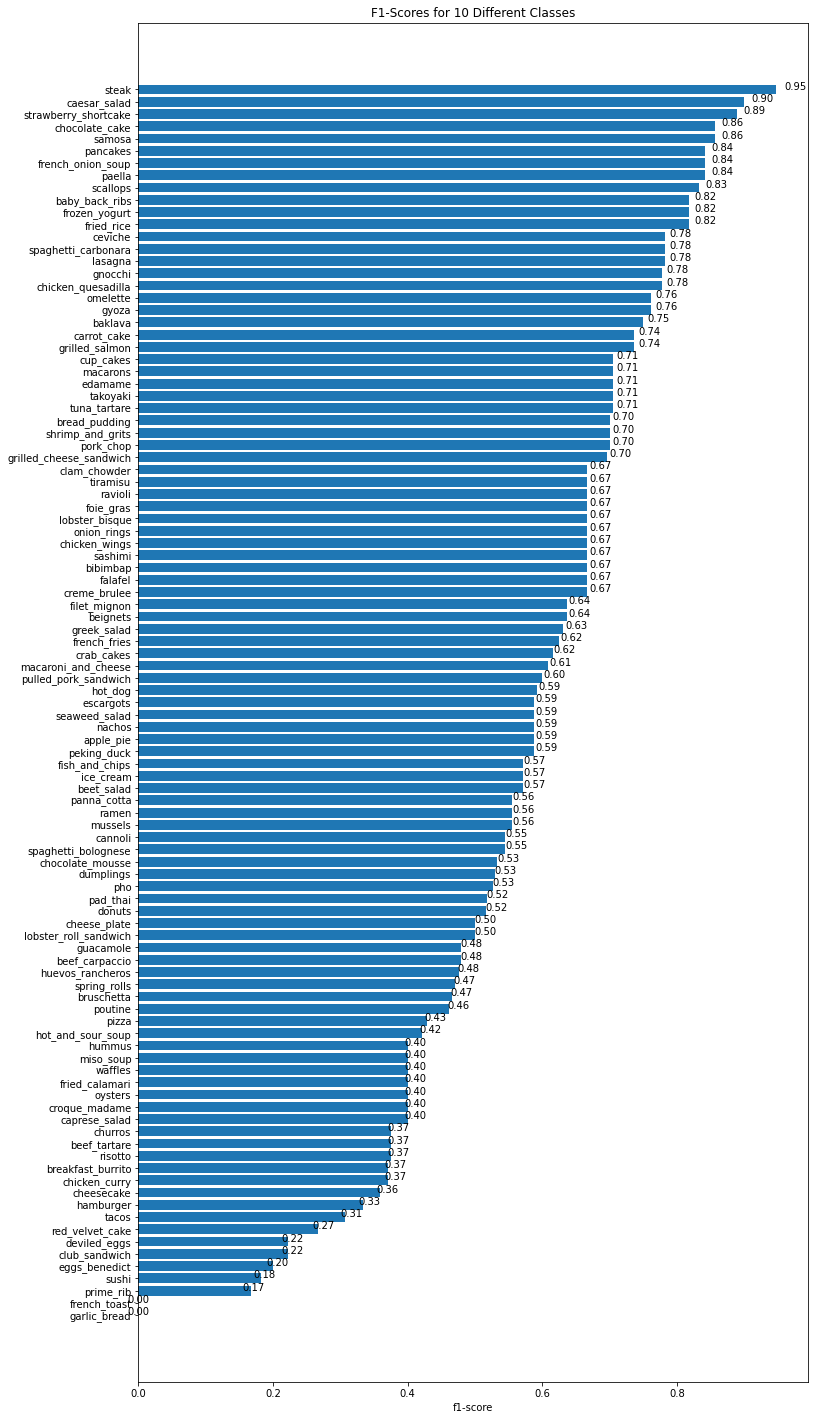

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_name"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects):
  
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)

In [ ]:
#Findings like these give us clues into where we could go next with our experiments.Perhaps we may have to collect more data on poor performing classes
#or perhaps the worst performing classes are just hard to make predictions on.

## Real word testing

In [ ]:
def prepare_image(path, img_shape=224, scale=True):
  # Read in the image
  img = tf.io.read_file(path)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

1/1 [==============================] - 0s 24ms/step


Text(0.5, 1.0, 'actual: grilled_salmon, pred: beignets, prob: 0.18')

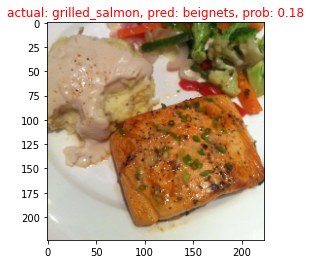

In [ ]:
random_image=get_random_image(directory=TEST_DIR)

image=prepare_image(random_image[1])

class_name=random_image[0]

pred_prob = model.predict(tf.expand_dims(image, axis=0))
pred_class = classes[pred_prob.argmax()] 


plt.imshow(image)

if class_name == pred_class: # Change the color of text based on whether prediction is right or wrong
    title_color = "g"
else:
  title_color = "r"
plt.title(f"actual: {class_name}, pred: {pred_class}, prob: {pred_prob.max():.2f}", c=title_color)

## **The project is currently under development**